In [1]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# + TensorFlow GPU setup (for GPflow/TF compute)
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

# ---- numpy bool8 compat ----
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ============================================================
# TensorFlow GPU setup (THIS is what makes TF/GPflow use GPU)
# ============================================================
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs (optional)

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Prevent TF from grabbing all VRAM at startup
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ TF version:", tf.__version__)
    print("✅ Built with CUDA:", tf.test.is_built_with_cuda())
    print("✅ GPUs:", gpus)
else:
    print("⚠️ TF version:", tf.__version__)
    print("⚠️ Built with CUDA:", tf.test.is_built_with_cuda())
    print("⚠️ GPUs: [] (TensorFlow will run on CPU)")

# ============================================================
# Dtypes for GPU-friendly pipeline
# ============================================================
# Env can stay float32; GP features should also be float32 to avoid slow casts.
DTYPE_NP = np.float32

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot

# ============================================================
# GP input feature mapping (6D)
# ============================================================
U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float32 by default (GPU-friendly).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics; that's OK)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

# ============================================================
# Edge respawn wrapper
# ============================================================
class EdgeRespawnWrapper(gym.Wrapper):
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True
            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs, _ = self.env.reset(seed=seed)

            terminated = False
            truncated = False

        return obs, float(reward), bool(terminated), bool(truncated), info

# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


/tmp/ipykernel_49515/3728359070.py:18: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


✅ TF version: 2.20.0
✅ Built with CUDA: True
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


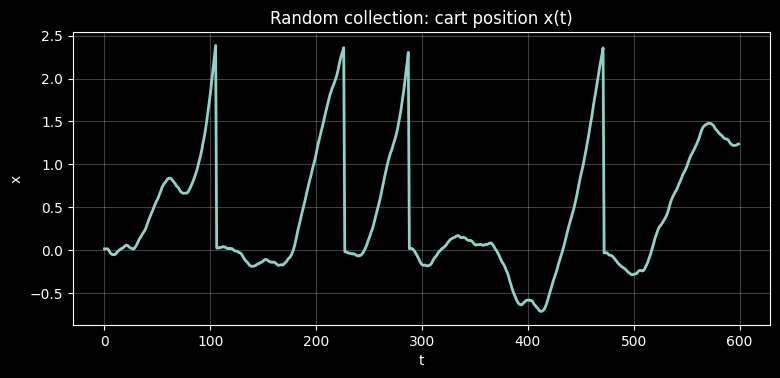

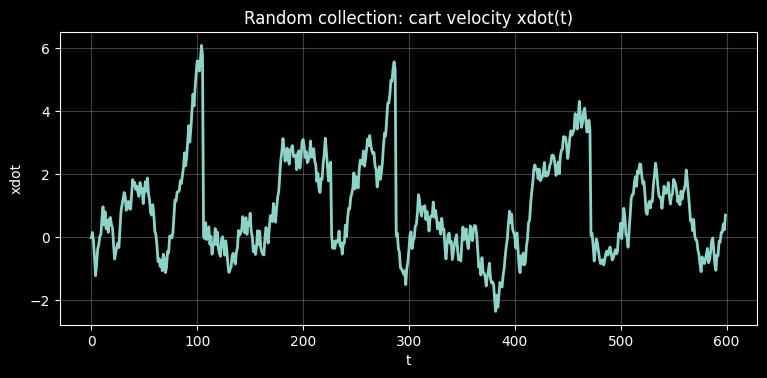

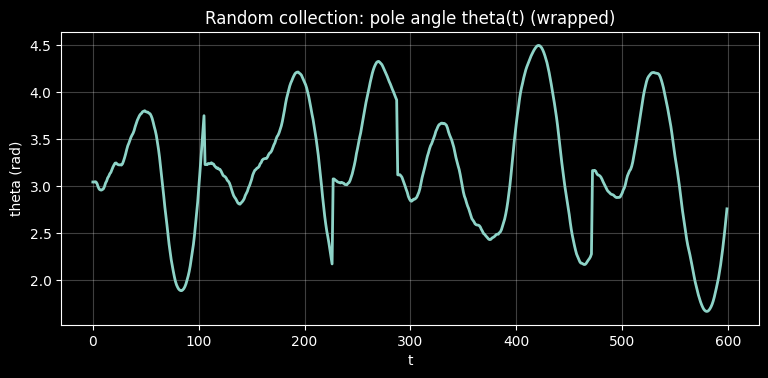

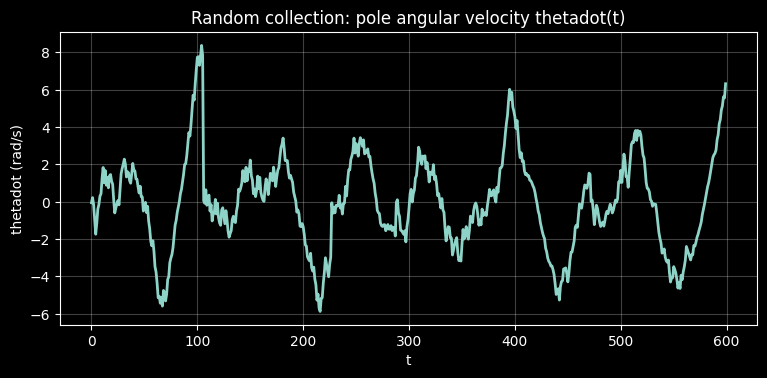

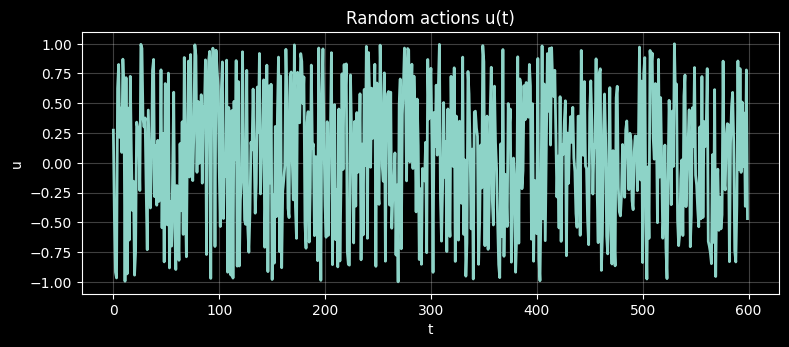

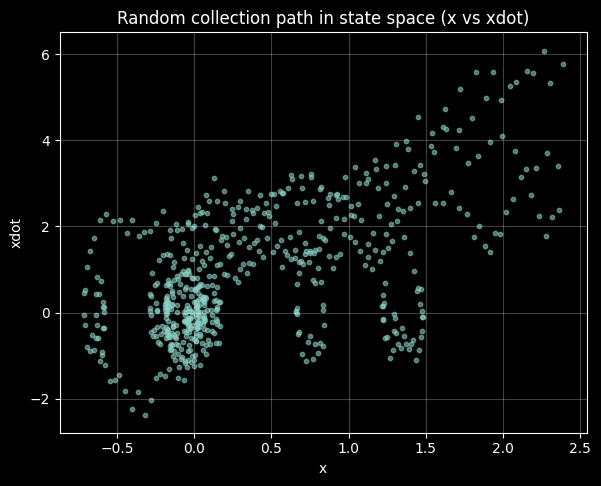

Collected X0 shape: (596, 6)  (PALSGP 6D features)
Targets shapes: (596, 1) (596, 1) (596, 1) (596, 1)
Kept=596  Dropped(respawn)=4  Resets=0


In [3]:
# ============================
# Cell 2 — Render the RANDOM collection path (and collect X,Y)  ✅ CartPole version (PALSGP-style)
#
# What you get:
#   - Runs random actions for n_steps (with resets as needed)
#   - Collects executed transitions in PALSGP feature space:
#       X0: (N,6)  = [tanh(x/2.4), tanh(xdot/3), sinθ, cosθ, tanh(thdot/8), u]
#       Ydx0, Ydxdot0, Ydth0, Ydthdot0  (each (N,1))  using wrapped Δtheta
#   - Records frames (rgb) and displays an inline animation (JS HTML)
#   - Plots trajectories:
#       x(t), xdot(t), theta(t), thetadot(t), action(t)
#       phase plot: x vs xdot
#
# IMPORTANT:
#   - ONLY depends on: make_env(...) from your Cell 1
#   - Does NOT depend on any OSGPR/PALSGP code
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image, ImageDraw

# ------------------------------------------------------------
# Action bounds (keep consistent everywhere)
# ------------------------------------------------------------
U_MIN = float(globals().get("U_MIN", -1.0))
U_MAX = float(globals().get("U_MAX", +1.0))

# ------------------------------------------------------------
# Angle wrapping (exactly what you want for Δtheta targets)
# ------------------------------------------------------------
def wrap_pi(theta):
    theta = float(theta)
    two_pi = 2.0 * np.pi
    return (theta + np.pi) % two_pi - np.pi

# ------------------------------------------------------------
# Robust obs -> (x, xdot, theta, thetadot)
#   Handles common formats:
#     - [x, xdot, theta, thetadot]
#     - [x, xdot, sin(theta), cos(theta), thetadot]
#     - [x, xdot, cos(theta), sin(theta), thetadot]  (we detect by magnitude)
# ------------------------------------------------------------
def obs_to_state(obs):
    obs = np.asarray(obs, dtype=np.float64).reshape(-1)
    if obs.size == 4:
        x, xdot, th, thdot = obs
        return float(x), float(xdot), float(th), float(thdot)

    if obs.size == 5:
        x, xdot, a, b, thdot = obs
        # a,b might be sin/cos or cos/sin. decide by which looks like cos near upright (≈1)
        # if either is near 1 often, treat that as cos.
        if abs(a) > 1.0 or abs(b) > 1.0:
            raise ValueError(f"Unexpected obs values (sin/cos should be within [-1,1]): {obs}")

        # Heuristic:
        # if |a| tends to be closer to 1 than |b|, guess a=cos, b=sin
        # else guess a=sin, b=cos
        if abs(a) >= abs(b):
            cos_th, sin_th = a, b
        else:
            sin_th, cos_th = a, b

        th = np.arctan2(sin_th, cos_th)
        return float(x), float(xdot), float(th), float(thdot)

    raise ValueError(f"Unsupported obs shape: {obs.shape} (size={obs.size}). Update obs_to_state() for your env.")

# ------------------------------------------------------------
# PALSGP feature map (6D)
#   X = [tanh(x/2.4), tanh(xdot/3), sinθ, cosθ, tanh(thdot/8), u]
# ------------------------------------------------------------
def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0):
    f0 = np.tanh(float(x) / float(x_scale))
    f1 = np.tanh(float(xdot) / float(v_scale))
    f2 = np.sin(float(theta))
    f3 = np.cos(float(theta))
    f4 = np.tanh(float(thetadot) / float(w_scale))
    f5 = float(u)
    return np.array([f0, f1, f2, f3, f4, f5], dtype=np.float64)

def batch_state_to_features(S, U,
                            x_scale=2.4, v_scale=3.0, w_scale=8.0):
    S = np.asarray(S, dtype=np.float64)
    U = np.asarray(U, dtype=np.float64).reshape(-1)
    x = S[:, 0]; xdot = S[:, 1]; th = S[:, 2]; thdot = S[:, 3]
    f0 = np.tanh(x / x_scale)
    f1 = np.tanh(xdot / v_scale)
    f2 = np.sin(th)
    f3 = np.cos(th)
    f4 = np.tanh(thdot / w_scale)
    f5 = U
    return np.stack([f0, f1, f2, f3, f4, f5], axis=1).astype(np.float64)

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)

    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8,
                         fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    ax = cx
    ay = y0 + 6

    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)

    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))

    return np.asarray(img, dtype=np.uint8)

# ------------------------------------------------------------
# Random collection (rendered)
# ------------------------------------------------------------
def collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=0,
    max_episode_steps=500,
    start_down=True,
    # rendering controls
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # edge-respawn handling (relies on env.step() putting info["respawned"]=True)
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=True,
):
    if "make_env" not in globals():
        raise RuntimeError("Cell 2 requires make_env(...) from your Cell 1.")

    rng = np.random.default_rng(seed)

    env_vis = make_env(
        render_mode=None,
        seed=seed,
        max_episode_steps=max_episode_steps,
        start_down=start_down,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, info = env_vis.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    X_list, Ydx_list, Ydxdot_list, Ydth_list, Ydthdot_list = [], [], [], [], []

    traj_x, traj_xdot, traj_th, traj_thdot, traj_u = [], [], [], [], []
    frames = []
    dropped = 0
    resets = 0

    for t in range(n_steps):
        u = float(rng.uniform(U_MIN, U_MAX))

        obs2, reward, terminated, truncated, info = env_vis.step(np.array([u], dtype=np.float32))
        x2, xdot2, th2, thdot2 = obs_to_state(obs2)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if respawned and drop_respawn_transitions:
            dropped += 1
        else:
            X_list.append(state_to_features(x, xdot, th, thdot, u))
            Ydx_list.append(x2 - x)
            Ydxdot_list.append(xdot2 - xdot)
            Ydth_list.append(wrap_pi(th2 - th))
            Ydthdot_list.append(thdot2 - thdot)

        traj_x.append(x);       traj_xdot.append(xdot)
        traj_th.append(th);     traj_thdot.append(thdot)
        traj_u.append(u)

        if (t % frame_stride) == 0:
            W, H = int(resize[0]), int(resize[1])
            frame = render_cartpole_frame_from_state(x2, th2, x_threshold=2.4, W=W, H=H)
            frames.append(frame)

        x, xdot, th, thdot = x2, xdot2, th2, thdot2

        if terminated or truncated:
            resets += 1
            obs, info = env_vis.reset(seed=int(seed + 123 + t))
            x, xdot, th, thdot = obs_to_state(obs)
            if verbose:
                print(f"[t={t:04d}] reset (terminated={terminated}, truncated={truncated})")

    env_vis.close()

    X0 = np.asarray(X_list, dtype=np.float64)
    Ydx0 = np.asarray(Ydx_list, dtype=np.float64).reshape(-1, 1)
    Ydxdot0 = np.asarray(Ydxdot_list, dtype=np.float64).reshape(-1, 1)
    Ydth0 = np.asarray(Ydth_list, dtype=np.float64).reshape(-1, 1)
    Ydthdot0 = np.asarray(Ydthdot_list, dtype=np.float64).reshape(-1, 1)

    traj = dict(
        x=np.asarray(traj_x, dtype=np.float64),
        xdot=np.asarray(traj_xdot, dtype=np.float64),
        theta=np.asarray(traj_th, dtype=np.float64),
        thetadot=np.asarray(traj_thdot, dtype=np.float64),
        u=np.asarray(traj_u, dtype=np.float64),
        dropped_respawn=int(dropped),
        resets=int(resets),
        steps=int(n_steps),
        kept=int(X0.shape[0]),
    )

    # ----------------------------
    # 1) show animation
    # ----------------------------
    if len(frames) > 0:
        fig = plt.figure(figsize=(resize[0] / 100, resize[1] / 100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(
            fig, animate_fn, frames=len(frames),
            interval=1000 / float(fps), blit=True
        )
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    else:
        print("⚠️ No frames collected (check frame_stride / resize).")

    # ----------------------------
    # 2) trajectory plots
    # ----------------------------
    tgrid = np.arange(len(traj["x"]))

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["x"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("x")
    plt.title("Random collection: cart position x(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["xdot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("xdot")
    plt.title("Random collection: cart velocity xdot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["theta"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("theta (rad)")
    plt.title("Random collection: pole angle theta(t) (wrapped)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["thetadot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("thetadot (rad/s)")
    plt.title("Random collection: pole angular velocity thetadot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.4))
    plt.plot(tgrid, traj["u"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("u")
    plt.title("Random actions u(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(6.8, 5.2))
    plt.scatter(traj["x"], traj["xdot"], s=10, alpha=0.55)
    plt.xlabel("x"); plt.ylabel("xdot")
    plt.title("Random collection path in state space (x vs xdot)")
    plt.grid(True, alpha=0.25); plt.show()

    print("Collected X0 shape:", X0.shape, " (PALSGP 6D features)")
    print("Targets shapes:", Ydx0.shape, Ydxdot0.shape, Ydth0.shape, Ydthdot0.shape)
    print(f"Kept={traj['kept']}  Dropped(respawn)={traj['dropped_respawn']}  Resets={traj['resets']}")
    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj

# ---- run it ----
SEED = 0
X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_transitions_rendered_cartpole(
    n_steps=600,
    seed=SEED,
    max_episode_steps=500,
    start_down=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
)

# Optional: quick distribution sanity
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=Ydth0.flatten(), nbinsx=60, name="Δtheta"))
fig.add_trace(go.Histogram(x=Ydthdot0.flatten(), nbinsx=60, name="Δthetadot"))
fig.update_layout(
    title="Initial random dataset: distribution of Δtheta and Δtheta_dot",
    barmode="overlay",
    xaxis_title="delta value",
    yaxis_title="count",
)
fig.update_traces(opacity=0.55)
fig.show()


In [4]:
# ===========================
# Cell 7 — EXACT GP (GPR) + MPPI (GPU TF) + Online Retrain + INLINE RENDER + SURFACES + SAVE  ✅ (OSGPR-free)
#
# ✅ Completely independent from OSGPR/PALSGP code:
#   - Uses ONLY: make_env(...) and the initial dataset from Cell 2:
#       X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0
#   - Re-defines: obs_to_state, wrap_pi, feature maps, MPPI, renderer, plotting, saving
#
# ✅ MPPI uses EXACT GP predictions for ALL rollouts:
#   - pred_bundle_tf comes from ExactGP caches (no subset, no inducing points)
#   - unc_fn_tf uses ExactGP(dxdot) predictive variance
#
# ✅ Online update:
#   - Collects new (Xnew, Ynew) from env transitions
#   - Appends to full dataset
#   - Retrains 4x exact GPR
#   - Rebuilds cached TF predictors immediately (MPPI uses the updated model next step)
#
# ✅ Timing like your Cell 6:
#   - total wall time from t=0 to end
#   - excludes visualization time (render frames, animation, per-update plots, final panel)
#   - prints only final totals
#
# ✅ Surfaces like your Cell 6:
#   - Stores GLOBAL surface history (ExactGP dxdot mean colored by std) each update
#   - Unified Std color scale across all updates
#   - Optional per-update plotting (default False)
#
# ✅ Saving:
#   - Saves gpflow params for 4 models + full dataset to a dedicated folder
#   - Does NOT touch / reuse any OSGPR artifacts
# ===========================

import os, time, pickle
import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image, ImageDraw
from datetime import datetime

# ------------------------------------------------------------
# 0) Require ONLY env + initial dataset from Cell 2
# ------------------------------------------------------------
need = ["make_env", "X0", "Ydx0", "Ydxdot0", "Ydth0", "Ydthdot0"]
missing = [k for k in need if k not in globals()]
if missing:
    raise RuntimeError(f"[Cell 7 ExactGP] Missing required globals from Cell 2 / Cell 1: {missing}")

# ------------------------------------------------------------
# 1) GPU sanity (same spirit as Cell 6)
# ------------------------------------------------------------
REQUIRE_GPU = True
LOG_DEVICE_PLACEMENT = False

print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

if REQUIRE_GPU:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) == 0:
        raise RuntimeError("REQUIRE_GPU=True but no GPU is visible to TensorFlow. Fix CUDA/TF install or set REQUIRE_GPU=False.")

# Use float64 (GPflow default)
gpflow.config.set_default_float(np.float64)
tf.keras.backend.set_floatx("float64")
DTYPE_TF = gpflow.default_float()
print("GPflow default float:", DTYPE_TF, " | TF floatx:", tf.keras.backend.floatx())

# ------------------------------------------------------------
# 2) Config (mirror Cell 6 structure)
# ------------------------------------------------------------
# MPPI
HORIZON    = 50
K_SAMPLES  = 256
SIGMA      = 0.6
LAMBDA     = 1.0

# Online update cadence
UPDATE_EVERY = 30
EXACT_ITERS_INIT   = 300
EXACT_ITERS_UPDATE = 200
EXACT_LR_INIT      = 0.02
EXACT_LR_UPDATE    = 0.02
EXACT_NOISE_INIT   = 1e-4
EXACT_NOISE_UPDATE = 1e-4

# Task / success
X_BAND      = 0.70
UPRIGHT_COS = 0.85
HOLD_STEPS  = 200

# Rendering (excluded from runtime)
RECORD_RGB   = True
RESIZE       = (720, 450)
FPS          = 10
FRAME_STRIDE = 2

# Exploration schedule (uncertainty chasing early)
EXPLORE_STEPS = 200
UNC_W_MAX     = 15.0
UNC_W_MIN     = 0.0
CENTER_W      = 1.0
U_W           = 0.005
UPRIGHT_W     = 2.0

# Action bounds (default if not defined)
U_MIN = float(globals().get("U_MIN", -1.0))
U_MAX = float(globals().get("U_MAX", +1.0))

# Optional per-update plotting (default OFF)
PLOT_EACH_UPDATE = False

# Unified uncertainty scale across ALL updates (same API as your Cell 6)
STD_CMIN_FIXED = 0.0
STD_FIXED_Q    = 0.5
STD_MODE       = "fixed"   # "fixed" or "grow_only"
STD_CMAX_FIXED = None

# Plot grid (fixed)
PLOT_X_MIN, PLOT_X_MAX = -2.4, 2.4
PLOT_V_MIN, PLOT_V_MAX = -3.0, 3.0
PLOT_N_GRID            = 60
PLOT_TH_FIXED          = 0.0
PLOT_THDOT_FIXED       = 0.0
PLOT_U_FIXED           = +1.0

# Store surfaces for final panel
STORE_GLOBAL_SURFACES = True
GLOBAL_SURF_HISTORY = []   # {update:int, Mean:(G,G), Std:(G,G)}

# ------------------------------------------------------------
# 3) Utilities: wrap, obs parsing, features (PALSGP-style features)
# ------------------------------------------------------------
def wrap_pi(theta):
    theta = float(theta)
    two_pi = 2.0 * np.pi
    return (theta + np.pi) % two_pi - np.pi

def obs_to_state(obs):
    obs = np.asarray(obs, dtype=np.float64).reshape(-1)
    if obs.size == 4:
        x, xdot, th, thdot = obs
        return float(x), float(xdot), float(th), float(thdot)

    if obs.size == 5:
        x, xdot, a, b, thdot = obs
        if abs(a) > 1.0 or abs(b) > 1.0:
            raise ValueError(f"Unexpected obs values (sin/cos should be within [-1,1]): {obs}")
        # heuristic: whichever is larger magnitude is likely cos(theta) more often (near upright)
        if abs(a) >= abs(b):
            cos_th, sin_th = a, b
        else:
            sin_th, cos_th = a, b
        th = np.arctan2(sin_th, cos_th)
        return float(x), float(xdot), float(th), float(thdot)

    raise ValueError(f"Unsupported obs size={obs.size}; update obs_to_state for your env.")

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0):
    return np.array([
        np.tanh(float(x) / x_scale),
        np.tanh(float(xdot) / v_scale),
        np.sin(float(theta)),
        np.cos(float(theta)),
        np.tanh(float(thetadot) / w_scale),
        float(u)
    ], dtype=np.float64)

def batch_state_to_features_np(S, U,
                               x_scale=2.4, v_scale=3.0, w_scale=8.0):
    S = np.asarray(S, dtype=np.float64)
    U = np.asarray(U, dtype=np.float64).reshape(-1)
    x = S[:, 0]; xdot = S[:, 1]; th = S[:, 2]; thdot = S[:, 3]
    return np.stack([
        np.tanh(x / x_scale),
        np.tanh(xdot / v_scale),
        np.sin(th),
        np.cos(th),
        np.tanh(thdot / w_scale),
        U
    ], axis=1).astype(np.float64)

# TF versions (GPU MPPI)
@tf.function
def wrap_pi_tf(theta):
    two_pi = tf.constant(2.0 * np.pi, dtype=DTYPE_TF)
    pi = tf.constant(np.pi, dtype=DTYPE_TF)
    return tf.math.floormod(theta + pi, two_pi) - pi

@tf.function
def batch_state_to_features_tf(S, U):
    x = S[:, 0]
    xdot = S[:, 1]
    th = S[:, 2]
    thdot = S[:, 3]
    f0 = tf.tanh(x / tf.cast(2.4, DTYPE_TF))
    f1 = tf.tanh(xdot / tf.cast(3.0, DTYPE_TF))
    f2 = tf.sin(th)
    f3 = tf.cos(th)
    f4 = tf.tanh(thdot / tf.cast(8.0, DTYPE_TF))
    f5 = U
    return tf.stack([f0, f1, f2, f3, f4, f5], axis=1)

# ------------------------------------------------------------
# 4) Pure-PIL renderer (kept fully local to this cell)
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)
    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8,
                         fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    ax = cx
    ay = y0 + 6

    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)
    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))
    return np.asarray(img, dtype=np.uint8)

# ------------------------------------------------------------
# 5) Plot grid (same idea as your Cell 6)
# ------------------------------------------------------------
def build_fixed_plot_grid():
    xg = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_N_GRID)
    vg = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_N_GRID)
    X, V = np.meshgrid(xg, vg)
    Xfeat_grid = np.vstack([
        state_to_features(x, xdot, PLOT_TH_FIXED, PLOT_THDOT_FIXED, PLOT_U_FIXED)
        for x, xdot in zip(X.ravel(), V.ravel())
    ]).astype(np.float64)
    return X, V, Xfeat_grid

PLOT_XMESH, PLOT_VMESH, PLOT_XFEAT_GRID = build_fixed_plot_grid()

def update_unified_std_scale(std_list, q=0.99, mode="fixed"):
    global STD_CMAX_FIXED
    all_std = np.concatenate([np.asarray(s, dtype=np.float64).reshape(-1) for s in std_list if s is not None], axis=0)
    if all_std.size == 0:
        if STD_CMAX_FIXED is None:
            STD_CMAX_FIXED = 1.0
        return (STD_CMIN_FIXED, STD_CMAX_FIXED)

    cand = float(np.quantile(all_std, q))
    cand = max(cand, 1e-8)

    if STD_CMAX_FIXED is None:
        STD_CMAX_FIXED = cand
    elif mode == "grow_only":
        STD_CMAX_FIXED = max(STD_CMAX_FIXED, cand)

    return (STD_CMIN_FIXED, STD_CMAX_FIXED)

def plot_surface_exactgp_dxdot(mean_grid, std_grid, title, std_clim=None):
    cmin = cmax = None
    if std_clim is not None:
        cmin, cmax = float(std_clim[0]), float(std_clim[1])

    surf = go.Surface(
        x=PLOT_XMESH, y=PLOT_VMESH, z=mean_grid,
        surfacecolor=std_grid,
        colorscale="Viridis",
        cmin=cmin, cmax=cmax,
        showscale=True,
        colorbar=dict(title="Std"),
        opacity=0.95,
    )
    fig = go.Figure(data=[surf])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=620
    )
    fig.show()

def make_global_progress_panel(history, std_clim, cols=3):
    if len(history) == 0:
        print("No surfaces stored (no updates happened).")
        return

    cols = int(max(1, cols))
    n = len(history)
    rows = int(np.ceil(n / cols))

    fig = make_subplots(
        rows=rows, cols=cols,
        specs=[[{"type": "surface"} for _ in range(cols)] for _ in range(rows)],
        subplot_titles=[f"Update #{h['update']}" for h in history] + [""] * (rows*cols - n),
        horizontal_spacing=0.02, vertical_spacing=0.04,
    )

    cmin, cmax = float(std_clim[0]), float(std_clim[1])

    for i, h in enumerate(history):
        r = i // cols + 1
        c = i % cols + 1
        show_scale = (i == 0)

        surf = go.Surface(
            x=PLOT_XMESH, y=PLOT_VMESH, z=h["Mean"],
            surfacecolor=h["Std"],
            colorscale="Viridis",
            cmin=cmin, cmax=cmax,
            showscale=show_scale,
            colorbar=(dict(title="Std") if show_scale else None),
            opacity=0.95
        )
        fig.add_trace(surf, row=r, col=c)

        scene_name = "scene" if (i == 0) else f"scene{i+1}"
        fig.layout[scene_name].update(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        )

    fig.update_layout(
        title=f"ExactGP GLOBAL Δxdot surfaces across updates (unified Std scale: [0, {cmax:.3g}])",
        height=350 * rows,
        margin=dict(l=0, r=0, b=0, t=60),
    )
    fig.show()

# ------------------------------------------------------------
# 6) Exact GP with cached TF predictor (SE-ARD, using gpflow GPR)
# ------------------------------------------------------------
class ExactGPCache:
    """
    Trains gpflow.models.GPR on (X,Y) and then builds a fast TF cached predictor:
      mu(x*) = K(X, x*)^T alpha, where alpha = Kxx^{-1} y
      var(x*) = k(x*,x*) - ||L^{-1} K(X,x*)||^2
    """
    def __init__(self, D, noise_var=1e-4, name="gpr"):
        self.D = int(D)
        self.noise_var = float(noise_var)
        self.name = str(name)

        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones((self.D,), dtype=np.float64), variance=1.0)
        self.model = None

        self._X = None
        self._L = None
        self._alpha = None

    def build_model(self, X_np, Y_np):
        X_np = np.asarray(X_np, dtype=np.float64)
        Y_np = np.asarray(Y_np, dtype=np.float64).reshape(-1, 1)

        Xtf = tf.convert_to_tensor(X_np, dtype=DTYPE_TF)
        Ytf = tf.convert_to_tensor(Y_np, dtype=DTYPE_TF)

        m = gpflow.models.GPR(
            data=(Xtf, Ytf),
            kernel=self.kernel,
            mean_function=gpflow.mean_functions.Zero()
        )
        m.likelihood.variance.assign(tf.cast(self.noise_var, DTYPE_TF))
        self.model = m
        return m

    def train_adam(self, iters=250, lr=0.02, clip_norm=10.0):
        if self.model is None:
            raise RuntimeError("Call build_model first.")
        opt = tf.keras.optimizers.Adam(lr)

        @tf.function
        def step():
            with tf.GradientTape() as tape:
                loss = self.model.training_loss()
            grads = tape.gradient(loss, self.model.trainable_variables)
            if clip_norm is not None:
                grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
            opt.apply_gradients([(g, v) for g, v in zip(grads, self.model.trainable_variables) if g is not None])
            return loss

        last = None
        for _ in range(int(iters)):
            last = step()
        return float(last.numpy())

    def rebuild_cache(self):
        if self.model is None:
            raise RuntimeError("No model.")
        Xtf, Ytf = self.model.data
        noise = tf.cast(self.model.likelihood.variance, DTYPE_TF)

        Kxx = self.model.kernel.K(Xtf) + noise * tf.eye(tf.shape(Xtf)[0], dtype=DTYPE_TF)
        L = tf.linalg.cholesky(Kxx)
        alpha = tf.linalg.cholesky_solve(L, Ytf)

        self._X = Xtf
        self._L = L
        self._alpha = alpha

    @tf.function
    def predict_mu_var(self, Xnew):
        Xnew = tf.cast(Xnew, DTYPE_TF)

        # K(X, X*)
        Kxs = self.model.kernel.K(self._X, Xnew)             # (N,B)
        mu = tf.linalg.matmul(Kxs, self._alpha, transpose_a=True)[:, 0]  # (B,)

        # var = k(x*,x*) - ||L^{-1}K||^2
        v = tf.linalg.triangular_solve(self._L, Kxs)         # (N,B)
        Kss = self.model.kernel.K_diag(Xnew)                 # (B,)
        var = Kss - tf.reduce_sum(tf.square(v), axis=0)
        var = tf.maximum(var, tf.cast(1e-12, DTYPE_TF))
        return mu, var

# ------------------------------------------------------------
# 7) Build predictor bundle for MPPI from 4 ExactGP caches
# ------------------------------------------------------------
def make_exact_predictors_bundle_tf(cache_dx, cache_dxdot, cache_dth, cache_dthdot):
    @tf.function
    def dx_mu(X):     return cache_dx.predict_mu_var(X)[0]
    @tf.function
    def dxdot_mu(X):  return cache_dxdot.predict_mu_var(X)[0]
    @tf.function
    def dth_mu(X):    return cache_dth.predict_mu_var(X)[0]
    @tf.function
    def thdot_mu(X):  return cache_dthdot.predict_mu_var(X)[0]

    @tf.function
    def unc_var_dxdot(X):
        return cache_dxdot.predict_mu_var(X)[1]

    return (dx_mu, dxdot_mu, dth_mu, thdot_mu), unc_var_dxdot

# ------------------------------------------------------------
# 8) MPPI cost + dynamics (TF GPU)
# ------------------------------------------------------------
@tf.function
def exploration_weight_tf(t):
    explore_steps_f = tf.cast(EXPLORE_STEPS, DTYPE_TF)
    t_f = tf.cast(t, DTYPE_TF)
    a = tf.clip_by_value(1.0 - t_f / tf.maximum(explore_steps_f, 1.0), 0.0, 1.0)
    return tf.cast(UNC_W_MIN, DTYPE_TF) + (tf.cast(UNC_W_MAX, DTYPE_TF) - tf.cast(UNC_W_MIN, DTYPE_TF)) * a

@tf.function
def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        tf.cast(UPRIGHT_W, DTYPE_TF) * (1.0 - tf.cos(th))
        + tf.cast(CENTER_W, DTYPE_TF) * tf.square(x - x_init)
        + tf.cast(U_W, DTYPE_TF) * tf.square(U)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - tf.cast(unc_w, DTYPE_TF) * tf.cast(unc_bonus, DTYPE_TF)
    return c

@tf.function
def terminal_cost_hold_like_tf(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = tf.zeros_like(th)
    good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, DTYPE_TF),
                          tf.abs(x - x_init) <= tf.cast(X_BAND, DTYPE_TF))
    cT = tf.where(good, cT - tf.cast(5.0, DTYPE_TF), cT)
    return cT

@tf.function
def gp_dynamics_step_batch_tf(S, U, pred_bundle_tf):
    pred_dx_tf, pred_dxdot_tf, pred_dth_tf, pred_dthdot_tf = pred_bundle_tf
    Xfeat = batch_state_to_features_tf(S, U)
    dx     = pred_dx_tf(Xfeat)
    dxdot  = pred_dxdot_tf(Xfeat)
    dth    = pred_dth_tf(Xfeat)
    dthdot = pred_dthdot_tf(Xfeat)

    S2 = tf.stack([
        S[:, 0] + dx,
        S[:, 1] + dxdot,
        wrap_pi_tf(S[:, 2] + dth),
        S[:, 3] + dthdot
    ], axis=1)
    return S2, Xfeat

@tf.function
def rollout_tube_features_tf(state0, u_seq, pred_bundle_tf):
    H = tf.shape(u_seq)[0]
    s = tf.identity(state0)
    tube = tf.TensorArray(dtype=DTYPE_TF, size=H)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, s, tube): return t < H

    def body(t, s, tube):
        u = u_seq[t]
        xfeat = batch_state_to_features_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0))[0]
        tube = tube.write(t, xfeat)
        s2, _ = gp_dynamics_step_batch_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0), pred_bundle_tf)
        return t+1, s2[0], tube

    _, _, tube = tf.while_loop(cond, body, [t, s, tube], parallel_iterations=1)
    return tube.stack()

@tf.function
def mppi_plan_gpu_exact_tf(state0, x_init, u_mean0, t_global,
                          pred_bundle_tf, unc_fn_tf,
                          horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                          base_seed=0):
    H = tf.cast(horizon, tf.int32)
    Kt = tf.cast(K, tf.int32)

    seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_global, tf.int32)], axis=0)
    eps = tf.random.stateless_normal((Kt, H), seed=seed, mean=0.0, stddev=tf.cast(sigma, DTYPE_TF), dtype=DTYPE_TF)
    U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    S = tf.tile(state0[None, :], [Kt, 1])
    total_cost = tf.zeros((Kt,), dtype=DTYPE_TF)

    unc_w = exploration_weight_tf(t_global)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, S, total_cost): return t < H

    def body(t, S, total_cost):
        Ut = U[:, t]
        S2, Xfeat = gp_dynamics_step_batch_tf(S, Ut, pred_bundle_tf)
        unc_bonus = unc_fn_tf(Xfeat)
        total_cost = total_cost + stage_cost_cartpole_tf(
            S, Ut, x_init=tf.cast(x_init, DTYPE_TF),
            unc_bonus=unc_bonus, unc_w=unc_w
        )
        return t+1, S2, total_cost

    _, S, total_cost = tf.while_loop(cond, body, [t, S, total_cost], parallel_iterations=1)
    total_cost = total_cost + terminal_cost_hold_like_tf(S, x_init=tf.cast(x_init, DTYPE_TF))

    cmin = tf.reduce_min(total_cost)
    w = tf.exp(-(total_cost - cmin) / tf.cast(lam, DTYPE_TF))
    wsum = tf.reduce_sum(w) + tf.cast(1e-12, DTYPE_TF)

    u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
    u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    tubeX = rollout_tube_features_tf(state0, u_mean, pred_bundle_tf)
    return u_mean[0], u_mean, tubeX, unc_w

def mppi_plan_gpu_exact(state, x_init, u_init, t_global, pred_bundle_tf, unc_fn_tf, base_seed=0):
    state0 = tf.convert_to_tensor(np.asarray(state, dtype=np.float64).reshape(4,), dtype=DTYPE_TF)
    x0     = tf.convert_to_tensor(float(x_init), dtype=DTYPE_TF)
    u0     = tf.convert_to_tensor(np.asarray(u_init, dtype=np.float64).reshape(-1,), dtype=DTYPE_TF)

    dev = "/GPU:0" if len(tf.config.list_logical_devices("GPU")) > 0 else "/CPU:0"
    if REQUIRE_GPU: dev = "/GPU:0"

    with tf.device(dev):
        u_first, u_mean, tubeX, unc_w = mppi_plan_gpu_exact_tf(
            state0, x0, u0, tf.convert_to_tensor(int(t_global), dtype=tf.int32),
            pred_bundle_tf=pred_bundle_tf,
            unc_fn_tf=unc_fn_tf,
            horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
            base_seed=int(base_seed)
        )
    return float(u_first.numpy()), u_mean.numpy(), tubeX.numpy(), float(unc_w.numpy())

# ------------------------------------------------------------
# 9) Success check (same logic as Cell 6)
# ------------------------------------------------------------
def success_hold_update(state, x_init, hold_count):
    x, xdot, th, thdot = state
    upright = (np.cos(th) >= UPRIGHT_COS)
    centered = (abs(x - x_init) <= X_BAND)
    hold_count = (hold_count + 1) if (upright and centered) else 0
    success = (hold_count >= HOLD_STEPS)
    return hold_count, success, upright, centered

# ------------------------------------------------------------
# 10) Training helpers: init + retrain exact GPs
# ------------------------------------------------------------
def train_all_exactgps(X_all, Ydx_all, Ydxdot_all, Ydth_all, Ydthdot_all,
                       iters, lr, noise_var):
    D = int(X_all.shape[1])

    cache_dx     = ExactGPCache(D, noise_var=noise_var, name="dx")
    cache_dxdot  = ExactGPCache(D, noise_var=noise_var, name="dxdot")
    cache_dth    = ExactGPCache(D, noise_var=noise_var, name="dth")
    cache_dthdot = ExactGPCache(D, noise_var=noise_var, name="dthdot")

    # Build + train
    cache_dx.build_model(X_all, Ydx_all);         cache_dx.train_adam(iters=iters, lr=lr)
    cache_dxdot.build_model(X_all, Ydxdot_all);   cache_dxdot.train_adam(iters=iters, lr=lr)
    cache_dth.build_model(X_all, Ydth_all);       cache_dth.train_adam(iters=iters, lr=lr)
    cache_dthdot.build_model(X_all, Ydthdot_all); cache_dthdot.train_adam(iters=iters, lr=lr)

    # Build caches
    cache_dx.rebuild_cache()
    cache_dxdot.rebuild_cache()
    cache_dth.rebuild_cache()
    cache_dthdot.rebuild_cache()

    pred_bundle_tf, unc_fn_tf = make_exact_predictors_bundle_tf(cache_dx, cache_dxdot, cache_dth, cache_dthdot)
    return cache_dx, cache_dxdot, cache_dth, cache_dthdot, pred_bundle_tf, unc_fn_tf

def exactgp_predict_mu_std_on_grid(cache_dxdot, Xfeat_grid_np):
    Xtf = tf.convert_to_tensor(np.asarray(Xfeat_grid_np, dtype=np.float64), dtype=DTYPE_TF)
    mu_tf, var_tf = cache_dxdot.predict_mu_var(Xtf)
    mu = mu_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var_tf.numpy().reshape(-1), 1e-12))
    return mu, std

# ------------------------------------------------------------
# 11) Saver (dedicated folder — no interaction with OSGPR saves)
# ------------------------------------------------------------
def _save_gpflow_params(model, path_pkl):
    vals = gpflow.utilities.read_values(model)
    with open(path_pkl, "wb") as f:
        pickle.dump(vals, f)

def save_exactgp_bundle(save_root="./saved_models_exactgp", prefix="cartpole_exactgp",
                        cache_dx=None, cache_dxdot=None, cache_dth=None, cache_dthdot=None,
                        X_all=None, Ydx_all=None, Ydxdot_all=None, Ydth_all=None, Ydthdot_all=None):
    os.makedirs(save_root, exist_ok=True)
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join(save_root, f"{prefix}_{stamp}")
    os.makedirs(save_dir, exist_ok=True)

    _save_gpflow_params(cache_dx.model,     os.path.join(save_dir, f"{prefix}_m_dx.pkl"))
    _save_gpflow_params(cache_dxdot.model,  os.path.join(save_dir, f"{prefix}_m_dxdot.pkl"))
    _save_gpflow_params(cache_dth.model,    os.path.join(save_dir, f"{prefix}_m_dth.pkl"))
    _save_gpflow_params(cache_dthdot.model, os.path.join(save_dir, f"{prefix}_m_dthdot.pkl"))

    np.savez(
        os.path.join(save_dir, f"{prefix}_data.npz"),
        X_all=np.asarray(X_all, dtype=np.float64),
        Ydx_all=np.asarray(Ydx_all, dtype=np.float64),
        Ydxdot_all=np.asarray(Ydxdot_all, dtype=np.float64),
        Ydth_all=np.asarray(Ydth_all, dtype=np.float64),
        Ydthdot_all=np.asarray(Ydthdot_all, dtype=np.float64),
    )

    print(f"[Saved ExactGP bundle] -> {save_dir}")
    return save_dir

# ------------------------------------------------------------
# 12) Episode runner with timing + surfaces + rendering
# ------------------------------------------------------------
def run_one_episode_exactgp_mppi_retrain_rgb_with_eval(
    max_steps=1000, seed=0, start_down=True, verbose=True,
    warmup_mppi=True
):
    global STD_CMAX_FIXED, GLOBAL_SURF_HISTORY

    # Full dataset starts as Cell2 random data
    X_all = np.asarray(X0, dtype=np.float64)
    Ydx_all     = np.asarray(Ydx0, dtype=np.float64).reshape(-1, 1)
    Ydxdot_all  = np.asarray(Ydxdot0, dtype=np.float64).reshape(-1, 1)
    Ydth_all    = np.asarray(Ydth0, dtype=np.float64).reshape(-1, 1)
    Ydthdot_all = np.asarray(Ydthdot0, dtype=np.float64).reshape(-1, 1)

    # Train initial exact GPs (counts in total runtime; not visualization)
    t0_train = time.perf_counter()
    cache_dx, cache_dxdot, cache_dth, cache_dthdot, pred_bundle_tf, unc_fn_tf = train_all_exactgps(
        X_all, Ydx_all, Ydxdot_all, Ydth_all, Ydthdot_all,
        iters=EXACT_ITERS_INIT, lr=EXACT_LR_INIT, noise_var=EXACT_NOISE_INIT
    )
    init_train_s = time.perf_counter() - t0_train
    if verbose:
        print(f"[ExactGP] init trained | N={len(X_all)} | init_train_s={init_train_s:.2f}")

    # Env
    env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps, start_down=start_down)
    obs, info = env.reset(seed=seed)
    s = np.array(obs_to_state(obs), dtype=np.float64)
    x_init = float(s[0])

    # TOTAL runtime excluding visualization
    t_wall_start = time.perf_counter()
    vis_time_s = 0.0
    mppi_time_s = 0.0

    # MPPI warmup (tracing/compile; included in total runtime by design)
    u_mean = np.zeros((HORIZON,), dtype=np.float64)
    if warmup_mppi:
        _ = mppi_plan_gpu_exact(
            state=s, x_init=x_init, u_init=u_mean, t_global=0,
            pred_bundle_tf=pred_bundle_tf, unc_fn_tf=unc_fn_tf,
            base_seed=seed
        )

    # Buffers
    frames = []
    total_reward = 0.0
    hold_count = 0
    updates = 0

    Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

    for t in range(max_steps):
        # PLAN (ExactGP)
        tp0 = time.perf_counter()
        u0, u_mean, tubeX, unc_w = mppi_plan_gpu_exact(
            state=s, x_init=x_init, u_init=u_mean, t_global=t,
            pred_bundle_tf=pred_bundle_tf, unc_fn_tf=unc_fn_tf,
            base_seed=seed
        )
        tp1 = time.perf_counter()
        mppi_time_s += (tp1 - tp0)

        # EXECUTE
        obs2, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
        s2 = np.array(obs_to_state(obs2), dtype=np.float64)
        total_reward += float(r)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if not respawned:
            Xbuf.append(state_to_features(s[0], s[1], s[2], s[3], float(u0)))
            ydx_buf.append([s2[0] - s[0]])
            ydxdot_buf.append([s2[1] - s[1]])
            ydth_buf.append([wrap_pi(s2[2] - s[2])])
            ydthdot_buf.append([s2[3] - s[3]])

        # RENDER (excluded)
        if RECORD_RGB and (t % FRAME_STRIDE == 0):
            tv0 = time.perf_counter()
            W, H = int(RESIZE[0]), int(RESIZE[1])
            frames.append(render_cartpole_frame_from_state(s2[0], s2[2], x_threshold=2.4, W=W, H=H))
            vis_time_s += (time.perf_counter() - tv0)

        # success
        hold_count, success, upright, centered = success_hold_update(s2, x_init, hold_count)
        if verbose and (t % 50 == 0):
            print(f"[t={t:03d}] u0={u0:+.2f}  unc_w={unc_w:.2f}  upright={upright} centered={centered} hold={hold_count}/{HOLD_STEPS}")

        # UPDATE (append + retrain exact GPs)
        if ((t + 1) % UPDATE_EVERY == 0) and (len(Xbuf) >= 10):
            updates += 1

            Xnew  = np.asarray(Xbuf, dtype=np.float64)
            ydx   = np.asarray(ydx_buf, dtype=np.float64).reshape(-1, 1)
            ydxd  = np.asarray(ydxdot_buf, dtype=np.float64).reshape(-1, 1)
            ydth  = np.asarray(ydth_buf, dtype=np.float64).reshape(-1, 1)
            ydthd = np.asarray(ydthdot_buf, dtype=np.float64).reshape(-1, 1)

            # append to full dataset
            X_all = np.vstack([X_all, Xnew])
            Ydx_all     = np.vstack([Ydx_all,     ydx])
            Ydxdot_all  = np.vstack([Ydxdot_all,  ydxd])
            Ydth_all    = np.vstack([Ydth_all,    ydth])
            Ydthdot_all = np.vstack([Ydthdot_all, ydthd])

            # clear buffers
            Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

            # retrain (new models each time => guaranteed no stale cached closures)
            cache_dx, cache_dxdot, cache_dth, cache_dthdot, pred_bundle_tf, unc_fn_tf = train_all_exactgps(
                X_all, Ydx_all, Ydxdot_all, Ydth_all, Ydthdot_all,
                iters=EXACT_ITERS_UPDATE, lr=EXACT_LR_UPDATE, noise_var=EXACT_NOISE_UPDATE
            )

            # store surface (ExactGP dxdot)
            if STORE_GLOBAL_SURFACES:
                muG, stdG = exactgp_predict_mu_std_on_grid(cache_dxdot, PLOT_XFEAT_GRID)
                MeanG = muG.reshape(PLOT_XMESH.shape)
                StdG  = stdG.reshape(PLOT_XMESH.shape)
                GLOBAL_SURF_HISTORY.append(dict(update=int(updates), Mean=MeanG, Std=StdG))
                std_clim = update_unified_std_scale([stdG.reshape(-1)], q=STD_FIXED_Q, mode=STD_MODE)

            # optional per-update plots (excluded)
            if PLOT_EACH_UPDATE:
                tv0 = time.perf_counter()
                title = f"ExactGP GLOBAL after update #{updates}: mean Δxdot colored by Std"
                plot_surface_exactgp_dxdot(MeanG, StdG, title=title, std_clim=(STD_CMIN_FIXED, STD_CMAX_FIXED))
                vis_time_s += (time.perf_counter() - tv0)

        # advance
        s = s2

        if success:
            if verbose:
                print(f"✅ SUCCESS at t={t} (held upright & centered for {HOLD_STEPS} steps)")
            break
        if terminated or truncated:
            if verbose:
                print(f"Episode ended at t={t} (terminated={terminated}, truncated={truncated})")
            break

    env.close()

    # animation (excluded)
    html = None
    if RECORD_RGB and len(frames) > 0:
        tv0 = time.perf_counter()
        fig = plt.figure(figsize=(RESIZE[0]/100, RESIZE[1]/100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(fig, animate_fn, frames=len(frames),
                                      interval=1000 / float(FPS), blit=True)
        plt.close(fig)
        html = HTML(ani.to_jshtml())
        display(html)
        vis_time_s += (time.perf_counter() - tv0)

    # totals
    total_wall_s = time.perf_counter() - t_wall_start
    runtime_excl_vis_s = max(total_wall_s - vis_time_s, 0.0)

    stats = dict(
        total_reward=float(total_reward),
        steps=int(t + 1),
        updates=int(updates),
        frames=int(len(frames)),
        x_init=float(x_init),
        hold_steps=int(hold_count),

        stored_global_surfaces=int(len(GLOBAL_SURF_HISTORY)),
        std_cmax_fixed=float(STD_CMAX_FIXED) if STD_CMAX_FIXED is not None else None,

        # timing
        total_wall_s=float(total_wall_s),
        vis_time_s=float(vis_time_s),
        runtime_excl_vis_s=float(runtime_excl_vis_s),
        mppi_time_s=float(mppi_time_s),
        init_train_s=float(init_train_s),
    )

    print("\n TOTAL wall time:", f"{total_wall_s:.3f} s")
    print("Visualization time excluded:", f"{vis_time_s:.3f} s")
    print(" Online runtime (MPPI+env+updates, NO vis):", f"{runtime_excl_vis_s:.3f} s")

    return stats, html, (cache_dx, cache_dxdot, cache_dth, cache_dthdot), (X_all, Ydx_all, Ydxdot_all, Ydth_all, Ydthdot_all)

# ------------------------------------------------------------
# 13) RUN + FINAL PANEL + SAVE
# ------------------------------------------------------------
stats, html, caches, data_all = run_one_episode_exactgp_mppi_retrain_rgb_with_eval(
    max_steps=1000,
    seed=0,
    start_down=True,
    verbose=True,
    warmup_mppi=True
)
print("\nEpisode stats:", stats)

# Final panel (excluded; happens after timing)
if (len(GLOBAL_SURF_HISTORY) > 0) and (STD_CMAX_FIXED is not None):
    make_global_progress_panel(GLOBAL_SURF_HISTORY, std_clim=(STD_CMIN_FIXED, STD_CMAX_FIXED), cols=3)
else:
    print("Final panel not shown (no updates / no stored surfaces / std scale not set).")

# Save (dedicated ExactGP folder)
cache_dx, cache_dxdot, cache_dth, cache_dthdot = caches
X_all, Ydx_all, Ydxdot_all, Ydth_all, Ydthdot_all = data_all

EXACT_SAVE_DIR = save_exactgp_bundle(
    save_root="./saved_models_exactgp",
    prefix="cartpole_exactgp",
    cache_dx=cache_dx, cache_dxdot=cache_dxdot, cache_dth=cache_dth, cache_dthdot=cache_dthdot,
    X_all=X_all, Ydx_all=Ydx_all, Ydxdot_all=Ydxdot_all, Ydth_all=Ydth_all, Ydthdot_all=Ydthdot_all
)
print("Saved ExactGP dir:", EXACT_SAVE_DIR)


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPflow default float: <class 'numpy.float64'>  | TF floatx: float64


I0000 00:00:1770078808.706947   49515 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5995 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1770078810.541267   49964 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x33cb3530


[ExactGP] init trained | N=596 | init_train_s=12.25
[t=000] u0=-1.00  unc_w=15.00  upright=False centered=True hold=0/200
[t=050] u0=-0.45  unc_w=11.25  upright=False centered=True hold=0/200
[t=100] u0=+1.00  unc_w=7.50  upright=True centered=False hold=0/200
[t=150] u0=+0.02  unc_w=3.75  upright=True centered=True hold=50/200
[t=200] u0=+0.75  unc_w=0.00  upright=True centered=True hold=100/200
[t=250] u0=+0.21  unc_w=0.00  upright=True centered=True hold=150/200
[t=300] u0=-0.35  unc_w=0.00  upright=True centered=True hold=200/200
✅ SUCCESS at t=300 (held upright & centered for 200 steps)



 TOTAL wall time: 146.508 s
Visualization time excluded: 2.413 s
 Online runtime (MPPI+env+updates, NO vis): 144.095 s

Episode stats: {'total_reward': 202.39863775881284, 'steps': 301, 'updates': 10, 'frames': 151, 'x_init': 0.013696168549358845, 'hold_steps': 200, 'stored_global_surfaces': 10, 'std_cmax_fixed': 0.03194296667724403, 'total_wall_s': 146.50846476600054, 'vis_time_s': 2.4131042229964805, 'runtime_excl_vis_s': 144.09536054300406, 'mppi_time_s': 35.13803450198975, 'init_train_s': 12.24814539399813}


[Saved ExactGP bundle] -> ./saved_models_exactgp/cartpole_exactgp_20260202_193607
Saved ExactGP dir: ./saved_models_exactgp/cartpole_exactgp_20260202_193607
